<a href="https://colab.research.google.com/github/leonardochernandes/IAMA/blob/main/read_data_Leonardo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objetivo:**
*indicar se existe dano ou não na estrutura do problema olhando para as informações de aceleração*

In [2]:
# execute this for the 1st time
# !pip install -r example-requirements.txt

# download file
!wget http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat # colab

# and place in folder data/

--2024-09-23 21:40:17--  http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat
Resolving helon.usuarios.rdc.puc-rio.br (helon.usuarios.rdc.puc-rio.br)... 139.82.34.12
Connecting to helon.usuarios.rdc.puc-rio.br (helon.usuarios.rdc.puc-rio.br)|139.82.34.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267634147 (255M)
Saving to: ‘data3SS2009.mat’

data3SS2009.mat     100%[===================>] 255.24M  19.8MB/s    in 15s     

2024-09-23 21:40:34 (16.9 MB/s) - ‘data3SS2009.mat’ saved [267634147/267634147]



In [3]:
import scipy.io as sio
import numpy as np
import os
from os import getcwd
from os.path import join
import matplotlib.pyplot as plt

In [4]:
fname = join(getcwd(),'data3SS2009.mat')

mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)  # vetor de labels (50 experimentos * 17 estados)
print(N, Chno, Nc)

# y = 0 (NOMINAL) / y = 1 (DANO)
y_target = y > 9  # Seria a saída desejada


8192 5 850


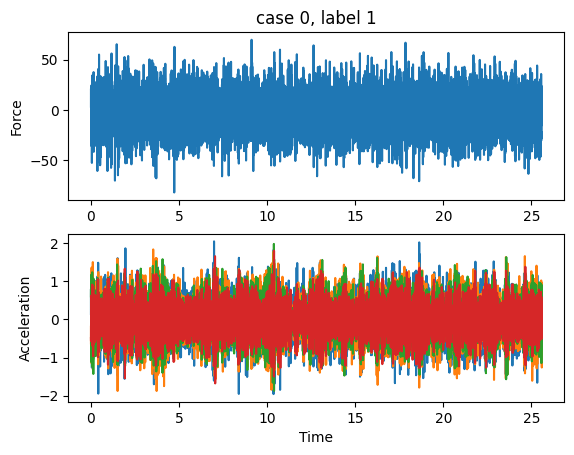

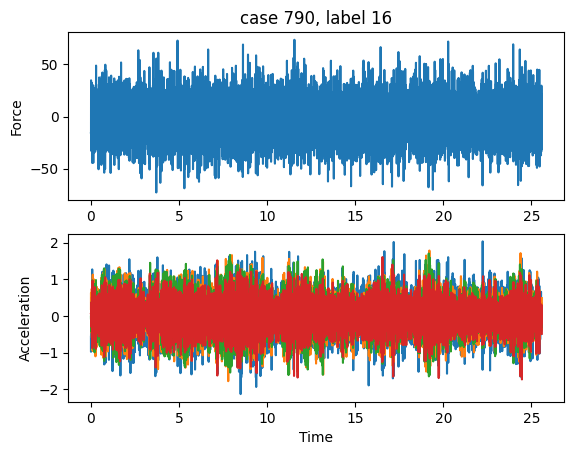

In [5]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

In [5]:
print(Ch2.shape)

(8192, 850)


# **Aula 02 - feature extraction and linear models**


4. Obtain Features

*4.a.a*
Obtendo a matriz X1

In [6]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
import numpy as np

na = 30
res1_list = []
res2_list = []
res3_list = []
res4_list = []

for i in range(Nc):
    res1 = AutoReg(Ch2[:,i], lags=na, trend='n').fit()
    res2 = AutoReg(Ch3[:,i], lags=na, trend='n').fit()
    res3 = AutoReg(Ch4[:,i], lags=na, trend='n').fit()
    res4 = AutoReg(Ch5[:,i], lags=na, trend='n').fit()

    res1_list.append(res1.params)
    res2_list.append(res2.params)
    res3_list.append(res3.params)
    res4_list.append(res4.params)

# Os parâmetros 'res' são de Ordem 30 com 120 linhas
res1 = np.array(res1_list)
res2 = np.array(res2_list)
res3 = np.array(res3_list)
res4 = np.array(res4_list)

X1 = np.concatenate([res1, res2, res3, res4], axis=1)
X1.shape

(850, 120)

*4.a.b*
Obtendo a matriz X2

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # 95% da variância (solicitado pelo prof)
X2 = pca.fit_transform(X1)

X2.shape

(850, 5)

*4.b*
Scale de todas as dimensões para -1 e 1



In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
X2_scaled = scaler.fit_transform(X2)

*4.c*
Visualizar e comparar X1 e X2 - mostrar procedimento de extração de características.

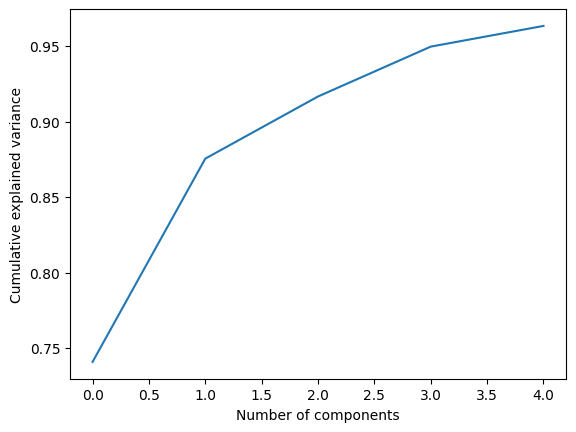

In [9]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

5. Softmax Model com *X2* (inputs) e *y* (outputs)

In [10]:
from sklearn.linear_model import LogisticRegression

model = logistic = LogisticRegression(max_iter=500) #hiper parâmetros aleatórios, somente para entendermos agora
model.fit(X2_scaled, y_target)

yhat = model.predict(X2_scaled)

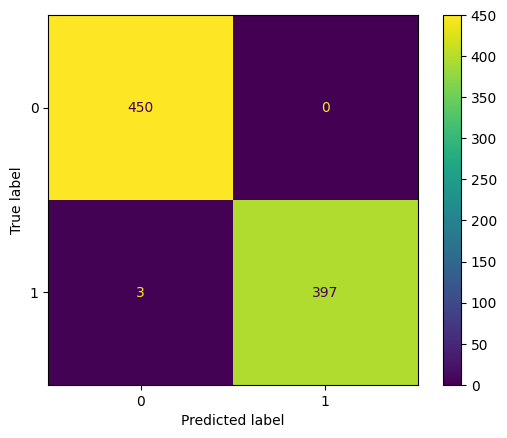

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_target, yhat)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

# **Aula 03 - SVM e KNN models**


*Sugestão para variar mais a abordagem:* Separação de dados em **train** e **teste**

In [12]:
from sklearn.model_selection import train_test_split

# 30% dados para teste
# X_train, X_test, y_train, y_test = train_test_split(X2_scaled, y_target, test_size=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X1, y_target, test_size=0.30, random_state=42)


In [13]:
X_train.shape

(595, 120)

1. Teste dos modelos SVM e kNN

*1.1* SVM example

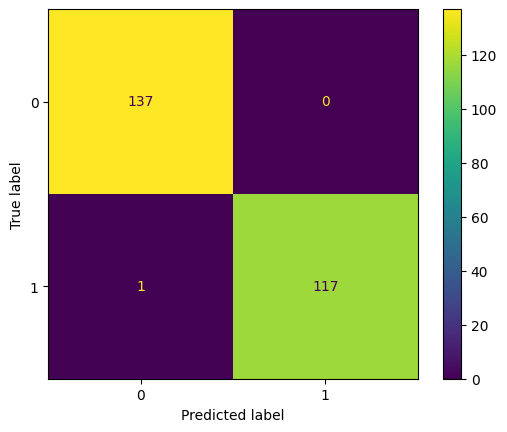

In [14]:
from sklearn.svm import SVC

# model_svc = SVC()

model_svc = SVC(kernel='rbf', C=0.1, gamma="auto") #hiper parâmetros aleatórios, somente para entender funcionamento

# model_svc.fit(X2_scaled, y_target)
# yhat_svc = model_svc.predict(X2_scaled)
model_svc.fit(X_train, y_train)         # Treinando
yhat_svc = model_svc.predict(X_test)    # Testando


cm_svc = confusion_matrix(y_test, yhat_svc)

disp_svc = ConfusionMatrixDisplay(confusion_matrix = cm_svc).plot()
plt.show()

*1.2* KNN example

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model.knn = KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='euclidean')   # Exemplo aula

model.knn.fit(X_train, y_train)

yhat_knn = model.knn.predict(X_test)

cm = confusion_matrix(y_test, yhat_knn)

disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

#### Testes aleatórios com os hiperarâmetros para a obtenção de resultados melhores para cada modelo.
Gerado um código para testes com as referências do `RandomizedSearchCV`

[Ref. 01](https://www.kaggle.com/code/arunimsamudra/k-nn-with-hyperparameter-tuning)

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

param_grids = []

# Define the parameter grids for SVC and KNN
param_grids.append( #SVC
    {
        "C":       stats.loguniform(1e-1, 1e3),
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "degree":  stats.randint(2, 5),
        "gamma":   stats.loguniform(1e-4, 1e0),
    }
)

param_grids.append( #KNN
    {
        "n_neighbors": stats.randint(2, 100),
        "weights": ["uniform", "distance"],
    }
)

model_svc = SVC()
model_knn = KNeighborsClassifier()

random_search_svc = RandomizedSearchCV(estimator=model_svc, param_distributions=param_grids[0], n_iter=100, cv=5, scoring='accuracy', n_jobs=-1)
random_search_knn = RandomizedSearchCV(estimator=model_knn, param_distributions=param_grids[1], n_iter=100, cv=5, scoring='accuracy', n_jobs=-1)

random_search_svc.fit(X_train, y_train)
random_search_knn.fit(X_train, y_train)

print("Best parameters for SVC (Randomized Search):", random_search_svc.best_params_)
print("Best score for SVC (Randomized Search):", random_search_svc.best_score_)
print("Best parameters for KNN (Randomized Search):", random_search_knn.best_params_)
print("Best score for KNN (Randomized Search):", random_search_knn.best_score_)

Best parameters for SVC (Randomized Search): {'C': 866.334734997238, 'degree': 2, 'gamma': 0.0006445156869330249, 'kernel': 'rbf'}
Best score for SVC (Randomized Search): 1.0
Best parameters for KNN (Randomized Search): {'n_neighbors': 3, 'weights': 'distance'}
Best score for KNN (Randomized Search): 1.0


Testando a comparação de modelos

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# parâmetros obtidos no código anterior
best_params_svc = {'C': 497.0144223350601, 'degree': 3, 'gamma': 0.6682625754343029, 'kernel': 'linear'}
best_params_knn = {'n_neighbors': 55, 'weights': 'distance'}

# Inicializando modelos com os parâmetros
model_svc = SVC(**best_params_svc)
model_knn = KNeighborsClassifier(**best_params_knn)


model_svc.fit(X_train, y_train)
model_knn.fit(X_train, y_train)

y_pred_svc = model_svc.predict(X_test)
y_pred_knn = model_knn.predict(X_test)


# Métricas SVC
accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc, average='weighted')
recall_svc = recall_score(y_test, y_pred_svc, average='weighted')
f1_svc = f1_score(y_test, y_pred_svc, average='weighted')

# Métricas KNN
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')


# Results
print(f"Results for SVC:")
print(f" - Acc: {accuracy_svc:.4f}")
print(f" - Precision: {precision_svc:.4f}")
print(f" - Recall: {recall_svc:.4f}")
print(f" - F1 Score: {f1_svc:.4f}")
print()

print(f"Results for KNN:")
print(f" - Acc: {accuracy_knn:.4f}")
print(f" - Precision: {precision_knn:.4f}")
print(f" - Recall: {recall_knn:.4f}")
print(f" - F1 Score: {f1_knn:.4f}")


# **AULA 04 - Aprendizado Supervisionado II**


So far we have used softmax, SVC, and kNN models. Now we will create them
again with the same 3-storey structure dataset but using hyperparameter
tuning by randomized search. To that end, provide the following items:

In [19]:
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn.metrics import accuracy_score

1. Split your dataset into a) training/validation and b) test datasets (e.g.60/40% ratio split)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X1, y_target, test_size=0.4, random_state=42)

In [33]:
# Definição dos modelos
models = []

models.append(("LRG", LogisticRegression))
models.append(("SVC", SVC))
models.append(("KNN", KNeighborsClassifier))

param_grids = []

param_grids.append(  # LogisticRegression
    {
        "LRG__C": stats.loguniform(1e-4, 1e0),
        "LRG__fit_intercept": [True, False],
        "LRG__solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
    }
)

param_grids.append(  # SVC
    {
        "SVC__C": stats.loguniform(1e-1, 1e3),
        "SVC__kernel": ["linear", "rbf", "poly", "sigmoid"],
        "SVC__degree": stats.randint(2, 5),
        "SVC__gamma": stats.loguniform(1e-4, 1e0),
    }
)

param_grids.append(  # KNN
    {
        "KNN__n_neighbors": stats.randint(2, 100),
        "KNN__weights": ["uniform", "distance"],
    }
)

2. Use randomized search with repeated cross-validation for hyperparameter
tuning. Use e.g.

a. Definição de `n_splits = 5` e `n_repeats = 50` para a `K-fold Cross-Validation`

b. Definição de um `n_iter = 100`, `n_jobs = -1` `cv = rkf ` (Gerado na instrução RepeatedKFold) e `scoring = accuracy` (método escolhido foi a acurácia)

In [22]:
# 2.a - Definição dos parâmetros para o k-fold cross-validation
n_splits = 5
n_repeats = 50
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# 2.a - Definição dos outros parâmetros necessários
n_iter = 100
n_jobs = -1
scoring = "accuracy"

best_estimators = []
for k, (model_name, model) in enumerate(models):

    clf = Pipeline([("scaler", StandardScaler()), (model_name, model())])

    param_grid = param_grids[k]

    # RandomizedSearch com cross-validation
    random_search = RandomizedSearchCV(
        clf, param_distributions=param_grid, n_iter=n_iter,
        scoring=scoring, n_jobs=n_jobs, cv=rkf, random_state=42, verbose=1
    )

    random_search.fit(X_train, y_train)

    best_estimators.append((model_name, random_search.best_estimator_))

    print(f"Melhores parâmetros para {model_name}: {random_search.best_params_}")

Fitting 250 folds for each of 100 candidates, totalling 25000 fits
Melhores parâmetros para LRG: {'LRG__C': 0.7706343825607372, 'LRG__fit_intercept': True, 'LRG__solver': 'newton-cg'}
Fitting 250 folds for each of 100 candidates, totalling 25000 fits
Melhores parâmetros para SVC: {'SVC__C': 24.81040974867808, 'SVC__degree': 4, 'SVC__gamma': 0.006071989493441302, 'SVC__kernel': 'poly'}
Fitting 250 folds for each of 100 candidates, totalling 25000 fits
Melhores parâmetros para KNN: {'KNN__n_neighbors': 16, 'KNN__weights': 'uniform'}


3. Try to compare with the results obtained with the default configurations of
each model constructor

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Comparação com modelos default - sem hiperparâmetros
default_estimators = []
for model_name, model in models:
    clf = Pipeline([("scaler", StandardScaler()), (model_name, model())])
    clf.fit(X_train, y_train)
    default_estimators.append((model_name, clf))


print("\nResultados para configurações default:")
for model_name, clf in default_estimators:
    y_pred = clf.predict(X_test)
    print(f"{model_name} - Acc: {accuracy_score(y_test, y_pred)}")

print("\nResultados para modelos com hiperparâmetros otimizados:")
for model_name, clf in best_estimators:
    y_pred = clf.predict(X_test)
    print(f"{model_name} - Acc: {accuracy_score(y_test, y_pred)}")


Resultados para configurações default:
LRG - Accuracy: 1.0
SVC - Accuracy: 1.0
KNN - Accuracy: 1.0
DTC - Accuracy: 0.9941176470588236
RFC - Accuracy: 0.9970588235294118
DTC - Accuracy: 0.9911764705882353
RFC - Accuracy: 0.9970588235294118
DTC - Accuracy: 0.9970588235294118
RFC - Accuracy: 0.9970588235294118

Resultados para modelos com hiperparâmetros otimizados:
LRG - Accuracy: 1.0
SVC - Accuracy: 1.0
KNN - Accuracy: 1.0
DTC - Accuracy: 0.9705882352941176


# **AULA 05 - Aprendizado Supervisionado III**

Adição dos modelos de `DecisionTree` e `RandomForest` às definições já feitas anteriormente

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

In [34]:
models.append(("DTC", DecisionTreeClassifier))
models.append(("RFC", RandomForestClassifier))

param_grids.append(  # DTC
    {
        "DTC__criterion": ["entropy", "gini"],
        "DTC__splitter": ["best", "random"],
        "DTC__max_depth": stats.randint(2, 20),
        "DTC__max_features": stats.uniform(),
    }
)

param_grids.append(  # RFC
    {
        "RFC__n_estimators": stats.randint(2, 100),
        "RFC__criterion": ["log_loss", "gini", "entropy"],
        "RFC__max_depth": stats.randint(2, 20),
        "RFC__max_features": stats.uniform(),
    }
)

*Script de Cross-validation e RandomizedSearch repetido para a obtenção dos melhores hiperparâmetros*

In [ ]:
n_splits = 5
n_repeats = 50
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

n_iter = 100
n_jobs = -1
scoring = "accuracy"

best_estimators = []
for k, (model_name, model) in enumerate(models):
    # Create an instance of the model here
    clf = Pipeline([("scaler", StandardScaler()), (model_name, model())])  # Create an instance of the model class

    param_grid = param_grids[k]

    random_search = RandomizedSearchCV(
        clf, param_distributions=param_grid, n_iter=n_iter,
        scoring=scoring, n_jobs=n_jobs, cv=rkf, random_state=42, verbose=1
    )

    random_search.fit(X_train, y_train)

    best_estimators.append((model_name, random_search.best_estimator_))

    print(f"Best parameters for {model_name}: {random_search.best_params_}")

Fitting 250 folds for each of 100 candidates, totalling 25000 fits
Best parameters for LRG: {'LRG__C': 0.7706343825607372, 'LRG__fit_intercept': True, 'LRG__solver': 'newton-cg'}
Fitting 250 folds for each of 100 candidates, totalling 25000 fits
Best parameters for SVC: {'SVC__C': 24.81040974867808, 'SVC__degree': 4, 'SVC__gamma': 0.006071989493441302, 'SVC__kernel': 'poly'}
Fitting 250 folds for each of 100 candidates, totalling 25000 fits
Best parameters for KNN: {'KNN__n_neighbors': 16, 'KNN__weights': 'uniform'}
Fitting 250 folds for each of 100 candidates, totalling 25000 fits
Best parameters for DTC: {'DTC__criterion': 'entropy', 'DTC__max_depth': 12, 'DTC__max_features': 0.19884240408880516, 'DTC__splitter': 'random'}
Fitting 250 folds for each of 100 candidates, totalling 25000 fits


# **AULA 06 - Aprendizado Não-Supervisionado**


1. Apply the k-means algorithm with the reduced dimensions;

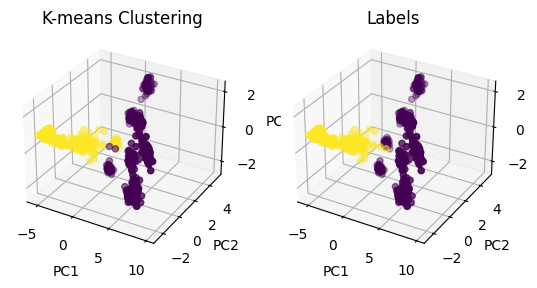

In [27]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Usar as 3 principais dimensões (pós PCA)
X_kmeans = X2[:, :3]

# Aplicar o K-means
kmeans = KMeans(n_clusters=2, random_state=42)  # Teste com 2 clusters (com ou sem danos)
kmeans.fit(X_kmeans)
labels_kmeans = kmeans.labels_

# Visualização 3D dos clusters gerados pelo K-means
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_kmeans[:, 0], X_kmeans[:, 1], X_kmeans[:, 2], c=labels_kmeans)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('K-means Clustering')

# Visualização 3D dos rótulos corretos
ax = fig.add_subplot(122, projection='3d')
ax.scatter(X_kmeans[:, 0], X_kmeans[:, 1], X_kmeans[:, 2], c=y_target)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('True Labels')

plt.show()


# matriz de Confusão
cm = confusion_matrix(y_target, labels_kmeans)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão: K-Means Clustering vs. True Labels")
plt.show()


2. Visualização do dataset usando **t-SNE**

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
# tsne = TSNE(n_components=2, random_state=42, perplexity=30)

X_tsne = tsne.fit_transform(X1)  # Usei X1 - sem o PCA

# Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_target)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Dataset')
plt.show()


plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_target, cmap='viridis')  # Use um colormap como 'viridis'
plt.colorbar(scatter)  # Adiciona uma barra de cores para indicar as classes
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Dataset')
plt.show()


3. Construir uma SVM de classificação de uma classe para modos nominais e de falha

In [ ]:
from sklearn.svm import OneClassSVM

X_nominal = X1[~y_target]

# Train the One-Class SVM model
ocsvm = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')
ocsvm.fit(X_nominal)

# Predict on the entire dataset
y_pred_ocsvm = ocsvm.predict(X1)


In [ ]:
# prompt: Based on the context of this notebook, build a one-class classification SVM for nominal and failure modes

from sklearn.svm import OneClassSVM

# Separate nominal and failure modes
X_nominal = X1[~y_target]  # Select data points where y_target is False (nominal)
X_failure = X1[y_target]  # Select data points where y_target is True (failure)

# Train the One-Class SVM model using the nominal data
ocsvm = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')
ocsvm.fit(X_nominal)

# Predict on the entire dataset using the trained model
y_pred_ocsvm = ocsvm.predict(X1)


# Supondo que a classe 1 seja a nominal (sem falhas)
X_nominal = X1[y_target == 1]  # Se 1 representar a condição nominal

# Treinamento do One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')
ocsvm.fit(X_nominal)

# Previsão no conjunto de dados completo
y_pred_ocsvm = ocsvm.predict(X1)

# Ajuste das predições: 1 -> nominal, -1 -> falha
y_pred_ocsvm = np.where(y_pred_ocsvm == 1, 1, 0)  # 1 para nominal, 0 para falhas

# Avaliação do desempenho
print("Matriz de Confusão:")
print(confusion_matrix(y_target, y_pred_ocsvm))

print("\nRelatório de Classificação:")
print(classification_report(y_target, y_pred_ocsvm, target_names=['Falha', 'Nominal']))

# **AULA 07 e 08 - Artificial Neural Networks (ANN)**
*Não realizada ainda.*


In [ ]:
"""
      NÃO FINALIZADO AINDA, SOMENTE CRIEI UM MODEOLO PARA TESTES SEGUINDO O SEGUINTE SCRIPT (testar funcionamento):
"""
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [ ]:
model = Sequential([Conv2D(32, kernel_size=(3, 3),
                           activation='relu',
                           input_shape=(28, 28, 1)),
])
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])

batch_size = 128
epochs = 10

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
model.save("test_model.h5")